In [10]:
import h5py as h5
import matplotlib.pyplot as plt
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from auton_survival.preprocessing import Scaler
import optuna
from sklearn.model_selection import ParameterGrid
#sys.path.append('/projects/EKOLEMEN/survival_tm/train_models/auton-survival')
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm.dsm_torch import DeepSurvivalMachinesTorch
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [11]:
with open('models/rt_fixed_rot_large.pkl', 'rb') as f:
    loaded_model = pickle.load(f)[0][0]

In [3]:
with open('data/pcs_testing_outputs.pkl', 'rb') as f:
    pcs_testing_outputs = pickle.load(f)

input_data = pcs_testing_outputs[0][55:56, :].astype(float)

survival_output = loaded_model._model.predict_survival(input_data, [400])

shape tensor([[8.1779, 7.8647, 7.7483]], dtype=torch.float64,
       grad_fn=<ExpandBackward0>)
scale tensor([[-0.1558, -0.5137, -0.3269]], dtype=torch.float64,
       grad_fn=<ExpandBackward0>)
temp 1.0
tensor([[9.1779, 7.0620, 8.7483]], dtype=torch.float64, grad_fn=<AddBackward0>) tensor([[-0.8009,  0.3629,  0.6728]], dtype=torch.float64,
       grad_fn=<AddBackward0>) tensor([[ -6.2264,   7.1584, -23.3568]], dtype=torch.float64,
       grad_fn=<DivBackward0>)


In [4]:
print(survival_output)

[[0.77176498]]


In [9]:
print(loaded_model._model.torch_model)

DeepSurvivalMachinesTorch(
  (act): Tanh()
  (shape): ParameterDict(  (1): Parameter containing: [torch.DoubleTensor of size 3])
  (scale): ParameterDict(  (1): Parameter containing: [torch.DoubleTensor of size 3])
  (gate): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=1000, out_features=3, bias=False)
    )
  )
  (scaleg): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=1000, out_features=3, bias=True)
    )
  )
  (shapeg): ModuleDict(
    (1): Sequential(
      (0): Linear(in_features=1000, out_features=3, bias=True)
    )
  )
  (embedding): Sequential(
    (0): Linear(in_features=38, out_features=100, bias=False)
    (1): ReLU6()
    (2): Linear(in_features=100, out_features=1000, bias=False)
    (3): ReLU6()
  )
)


In [12]:
a = loaded_model._model.torch_model

print(a.embedding)
print(a.act)
print(a.shapeg['1'])
print(a.shape['1'].expand(179, -1))
print(a.scaleg['1'])
print(a.scale['1'].expand(179, -1))
print(a.gate['1'])
print(a.temp)

Sequential(
  (0): Linear(in_features=38, out_features=100, bias=False)
  (1): ReLU6()
  (2): Linear(in_features=100, out_features=1000, bias=False)
  (3): ReLU6()
)
Tanh()
Sequential(
  (0): Linear(in_features=1000, out_features=3, bias=True)
)
tensor([[8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
        [8.6960, 7.8903, 9.8504],
      

In [13]:
import torch
import torch.nn as nn

# Assuming 'a' is your original model
class EmbeddingModel(nn.Module):
    def __init__(self, original_model):
        super(EmbeddingModel, self).__init__()
        self.embedding = original_model.embedding
        # onnx2keras doesn't support relu6
        self.embedding[1] = nn.ReLU()
        self.embedding[3] = nn.ReLU()
        #self.embedding[5] = nn.ReLU()
        #self.embedding[7] = nn.ReLU()
        #self.embedding[9] = nn.ReLU()
    def forward(self, x):
        return self.embedding(x)

class ShapegModel(nn.Module):
    def __init__(self, original_model):
        super(ShapegModel, self).__init__()
        self.shapeg = original_model.shapeg['1']  # Access the specific module

    def forward(self, x):
        return self.shapeg(x)
    
class ScalegModel(nn.Module):
    def __init__(self, original_model):
        super(ScalegModel, self).__init__()
        self.scaleg = original_model.scaleg['1']  # Access the specific module

    def forward(self, x):
        return self.scaleg(x)
    
class GateModel(nn.Module):
    def __init__(self, original_model):
        super(GateModel, self).__init__()
        self.gate = original_model.gate['1']  # Access the specific module

    def forward(self, x):
        return self.gate(x)

scaleg = ScalegModel(a)
gate = GateModel(a)
shapeg = ShapegModel(a)
embedding = EmbeddingModel(a)

In [18]:
import onnx

# make a dummy input with the correct dimensions for your model
dummy_input = torch.randn(1, 38).double()
torch.onnx.export(embedding, dummy_input, 'embedding.onnx', verbose=True, input_names = ['input'], output_names = ['output'])

def sanitize_name(name):
    return name.lstrip('/').replace('/', '_').replace('.', '_')

def rename_nodes(model):
    for node in model.graph.node:
        node.name = sanitize_name(node.name)
        node.input[:] = [sanitize_name(inp) for inp in node.input]
        node.output[:] = [sanitize_name(out) for out in node.output]
    for input in model.graph.input:
        input.name = sanitize_name(input.name)
    for output in model.graph.output:
        output.name = sanitize_name(output.name)
    for initializer in model.graph.initializer:
        initializer.name = sanitize_name(initializer.name)

onnx_model = onnx.load('embedding.onnx')
rename_nodes(onnx_model)
onnx.save(onnx_model, 'sanitized_embedding.onnx')

from onnx2keras import onnx_to_keras
import onnx
onnx_model = onnx.load('sanitized_embedding.onnx')

keras_model = onnx_to_keras(onnx_model, ['input'])
keras_model.save('tape_rtprofile_embedding.h5')

Exported graph: graph(%input : Double(1, 38, strides=[38, 1], requires_grad=0, device=cpu),
      %onnx::MatMul_9 : Double(38, 100, strides=[1, 38], requires_grad=0, device=cpu),
      %onnx::MatMul_10 : Double(100, 1000, strides=[1, 100], requires_grad=0, device=cpu)):
  %/embedding/embedding.0/MatMul_output_0 : Double(1, 100, strides=[100, 1], requires_grad=1, device=cpu) = onnx::MatMul[onnx_name="/embedding/embedding.0/MatMul"](%input, %onnx::MatMul_9), scope: __main__.EmbeddingModel::/torch.nn.modules.container.Sequential::embedding/torch.nn.modules.linear.Linear::embedding.0 # /home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/torch/nn/modules/linear.py:116:0
  %/embedding/embedding.1/Relu_output_0 : Double(1, 100, strides=[100, 1], requires_grad=1, device=cpu) = onnx::Relu[onnx_name="/embedding/embedding.1/Relu"](%/embedding/embedding.0/MatMul_output_0), scope: __main__.EmbeddingModel::/torch.nn.modules.container.Sequential::embedding/torch.nn.modules.activation.ReLU::em

2024-07-02 19:54:13.942411: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 19:54:14.496163: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 19:54:14.496196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 19:54:14.547031: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 19:54:14.572537: I tensorflow/core/platform/cpu_feature_guar

/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
DEBUG:h5py._conv:Creating converter from 5 to 3


In [19]:
# convert relu to relu6 in keras model
from keras.models import Sequential
from keras.layers import ReLU

# Assume 'model' is your pre-loaded Keras sequential model
for i, layer in enumerate(keras_model.layers):
    if isinstance(layer, ReLU):
        keras_model.layers[i] = ReLU(max_value=6, name=layer.name)  # Replacing ReLU with ReLU6

# Save the updated model if necessary
keras_model.save('tape_rtprofile_embedding.h5')


In [21]:
import onnx

# make a dummy input with the correct dimensions for your model
dummy_input = torch.randn(1, 1000).double()
torch.onnx.export(scaleg, dummy_input, 'scaleg.onnx', verbose=True, input_names = ['input'], output_names = ['output'])

def sanitize_name(name):
    return name.lstrip('/').replace('/', '_').replace('.', '_')

def rename_nodes(model):
    for node in model.graph.node:
        node.name = sanitize_name(node.name)
        node.input[:] = [sanitize_name(inp) for inp in node.input]
        node.output[:] = [sanitize_name(out) for out in node.output]
    for input in model.graph.input:
        input.name = sanitize_name(input.name)
    for output in model.graph.output:
        output.name = sanitize_name(output.name)
    for initializer in model.graph.initializer:
        initializer.name = sanitize_name(initializer.name)

onnx_model = onnx.load('scaleg.onnx')
rename_nodes(onnx_model)
onnx.save(onnx_model, 'sanitized_scaleg.onnx')

from onnx2keras import onnx_to_keras
import onnx
onnx_model = onnx.load('sanitized_scaleg.onnx')

keras_model = onnx_to_keras(onnx_model, ['input'])
keras_model.save('tape_rtprofile_scaleg.h5')

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight scaleg_0_weight with shape (3, 1000).
DEBUG:onnx2keras:Found weight scaleg_0_bias with shape (3,).
DEBUG:onnx2keras:Found input input with shape [1000]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: output
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input).
DEBUG:onnx2keras:Check input 1 (name scaleg_0_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, 

Exported graph: graph(%input : Double(1, 1000, strides=[1000, 1], requires_grad=0, device=cpu),
      %scaleg.0.weight : Double(3, 1000, strides=[1000, 1], requires_grad=1, device=cpu),
      %scaleg.0.bias : Double(3, strides=[1], requires_grad=1, device=cpu)):
  %output : Double(1, 3, strides=[3, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/scaleg/scaleg.0/Gemm"](%input, %scaleg.0.weight, %scaleg.0.bias), scope: __main__.ScalegModel::/torch.nn.modules.container.Sequential::scaleg/torch.nn.modules.linear.Linear::scaleg.0 # /home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/torch/nn/modules/linear.py:116:0
  return (%output)



/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
import onnx

# make a dummy input with the correct dimensions for your model
dummy_input = torch.randn(1, 1000).double()
torch.onnx.export(shapeg, dummy_input, 'shapeg.onnx', verbose=True, input_names = ['input'], output_names = ['output'])

def sanitize_name(name):
    return name.lstrip('/').replace('/', '_').replace('.', '_')

def rename_nodes(model):
    for node in model.graph.node:
        node.name = sanitize_name(node.name)
        node.input[:] = [sanitize_name(inp) for inp in node.input]
        node.output[:] = [sanitize_name(out) for out in node.output]
    for input in model.graph.input:
        input.name = sanitize_name(input.name)
    for output in model.graph.output:
        output.name = sanitize_name(output.name)
    for initializer in model.graph.initializer:
        initializer.name = sanitize_name(initializer.name)

onnx_model = onnx.load('shapeg.onnx')
rename_nodes(onnx_model)
onnx.save(onnx_model, 'sanitized_shapeg.onnx')

from onnx2keras import onnx_to_keras
import onnx
onnx_model = onnx.load('sanitized_shapeg.onnx')

keras_model = onnx_to_keras(onnx_model, ['input'])
keras_model.save('tape_rtprofile_shapeg.h5')

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight shapeg_0_weight with shape (3, 1000).
DEBUG:onnx2keras:Found weight shapeg_0_bias with shape (3,).
DEBUG:onnx2keras:Found input input with shape [1000]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Gemm
DEBUG:onnx2keras:node_name: output
DEBUG:onnx2keras:node_params: {'alpha': 1.0, 'beta': 1.0, 'transB': 1, 'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input).
DEBUG:onnx2keras:Check input 1 (name shapeg_0_weight).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, 

Exported graph: graph(%input : Double(1, 1000, strides=[1000, 1], requires_grad=0, device=cpu),
      %shapeg.0.weight : Double(3, 1000, strides=[1000, 1], requires_grad=1, device=cpu),
      %shapeg.0.bias : Double(3, strides=[1], requires_grad=1, device=cpu)):
  %output : Double(1, 3, strides=[3, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="/shapeg/shapeg.0/Gemm"](%input, %shapeg.0.weight, %shapeg.0.bias), scope: __main__.ShapegModel::/torch.nn.modules.container.Sequential::shapeg/torch.nn.modules.linear.Linear::shapeg.0 # /home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/torch/nn/modules/linear.py:116:0
  return (%output)



In [25]:
import onnx

# make a dummy input with the correct dimensions for your model
dummy_input = torch.randn(1, 1000).double()
torch.onnx.export(gate, dummy_input, 'gate.onnx', verbose=True, input_names = ['input'], output_names = ['output'])

def sanitize_name(name):
    return name.lstrip('/').replace('/', '_').replace('.', '_')

def rename_nodes(model):
    for node in model.graph.node:
        node.name = sanitize_name(node.name)
        node.input[:] = [sanitize_name(inp) for inp in node.input]
        node.output[:] = [sanitize_name(out) for out in node.output]
    for input in model.graph.input:
        input.name = sanitize_name(input.name)
    for output in model.graph.output:
        output.name = sanitize_name(output.name)
    for initializer in model.graph.initializer:
        initializer.name = sanitize_name(initializer.name)

onnx_model = onnx.load('gate.onnx')
rename_nodes(onnx_model)
onnx.save(onnx_model, 'sanitized_gate.onnx')

from onnx2keras import onnx_to_keras
import onnx
onnx_model = onnx.load('sanitized_gate.onnx')

keras_model = onnx_to_keras(onnx_model, ['input'])
keras_model.save('tape_rtprofile_gate.h5')

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight onnx::MatMul_4 with shape (1000, 3).
DEBUG:onnx2keras:Found input input with shape [1000]
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: MatMul
DEBUG:onnx2keras:node_name: output
DEBUG:onnx2keras:node_params: {'change_ordering': False, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input).
DEBUG:onnx2keras:Check input 1 (name onnx::MatMul_4).
DEBUG:onnx2keras:The input not found in layers / model inputs.
DEBUG:onnx2keras:Found in weights, add as a numpy constant.
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:gemm:Convert GEMM 

Exported graph: graph(%input : Double(1, 1000, strides=[1000, 1], requires_grad=0, device=cpu),
      %onnx::MatMul_4 : Double(1000, 3, strides=[1, 1000], requires_grad=0, device=cpu)):
  %output : Double(1, 3, strides=[3, 1], requires_grad=1, device=cpu) = onnx::MatMul[onnx_name="/gate/gate.0/MatMul"](%input, %onnx::MatMul_4), scope: __main__.GateModel::/torch.nn.modules.container.Sequential::gate/torch.nn.modules.linear.Linear::gate.0 # /home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/torch/nn/modules/linear.py:116:0
  return (%output)



/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TEST OUTPUT CORRECTNESS

In [71]:
with open('data/rt_x_train_pca.pkl', 'rb') as f:
    x_train = pickle.load(f)
with open('data/rt_e.pkl', 'rb') as f:
    e = np.array(pickle.load(f))
with open('data/rt_t.pkl', 'rb') as f:
    t = np.array(pickle.load(f))
with open('data/rt_shots.pkl', 'rb') as f:
    shots_list = pickle.load(f)

In [20]:
with open('data/x_temp_pca.pkl', 'rb') as f:
    x_train = pickle.load(f)

In [59]:
with open('models/rt_model_latest_pcb.pkl', 'rb') as file:
    loaded_model = pickle.load(file)[0][0]

model = loaded_model._model._gen_torch_model(38, 'Adam', 1)

embedding = model.embedding
shapeg = model.shapeg['1']
scaleg = model.scaleg['1']
gate = model.gate['1']

In [93]:
with open('data/rt_x_pca_bms_pcb.pkl', 'rb') as f:
    x_train_df = pickle.load(f)
    x_train = torch.tensor(np.array(x_train_df)[151900:152000, :]).float()

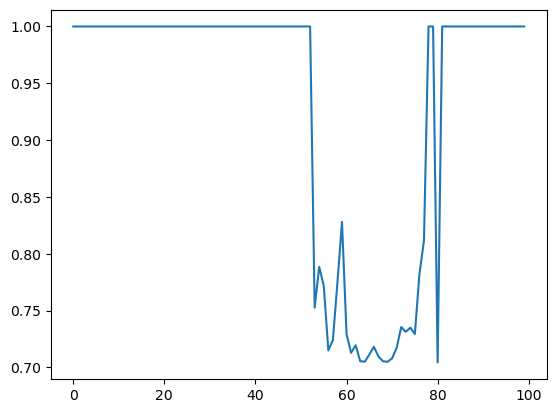

In [96]:
with open('models/rt_model_latest_pcb.pkl', 'rb') as f:
    loaded_model = pickle.load(f)[0][0]

'''model_output = model(wanted_x_train_tensor)
embedding_output = embedding(wanted_x_train_tensor)
shapeg_output = shapeg(embedding_output)
scaleg_output = scaleg(embedding_output)
gate_output = gate(embedding_output)'''

survival_output = loaded_model._model.predict_survival(np.array(x_train.double()), [400])
plt.plot(survival_output)
combined_results = [np.array(x_train.detach()), np.array(embedding(x_train).detach()), np.array(shapeg(embedding(x_train).detach()).detach()), np.array(scaleg(embedding(x_train).detach()).detach()), np.array(gate(embedding(x_train).detach()).detach()), survival_output]

with open('data/pcs_testing_outputs.pkl', 'wb') as f:
    pickle.dump(combined_results, f)

In [3]:
with open('data/dummy_x.pkl', 'rb') as f:
    x_train_df = pickle.load(f)
with open('data/rt_filtered_shots_pcb.pkl', 'rb') as f:
    shots_list = list(pickle.load(f))

In [44]:
x_train_tensor = torch.tensor(x_train_df.values).float()
wanted_shot = '180636'
start_index = shots_list.index(wanted_shot)
end_index = len(shots_list) - 1 - shots_list[::-1].index(wanted_shot)


wanted_x_train_tensor = x_train_tensor[start_index:end_index]

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [10]:
print(shapeg_output)
print(np.tanh(np.array(shapeg_output.detach())))

tensor([[ 1.1842, -0.0563, -3.2684, -3.4455, -0.8134, -0.3632,  0.2885,  1.2793,
         -1.6063, -0.2875]], grad_fn=<AddmmBackward0>)
[[ 0.8287846  -0.05627893 -0.99710596 -0.99796814 -0.67143893 -0.3480558
   0.280745    0.8563067  -0.9226067  -0.27980506]]


In [58]:
tens = torch.tensor([[-3.4724, -1.1324, -1.9546, -5.2052, -3.3769, -3.1208, -2.0945, -1.9498,
         -3.9463, -1.9922]])
a = torch.logsumexp(tens, dim=1)
np.exp(a)

tensor([0.9998])

In [4]:
with open('data/965546_tape.pkl', 'rb') as f:
    tape = pickle.load(f)
print(tape['TPSNE1']['data'].shape)

pcs_scalars = ['TPSPINJ', 'TPSTINJ', 'TPSBETAN', 'TPSQMIN', 'TPSECH', 'TPSIP', 'TPSBT', 'TPSLI', 'TPSAMINOR', 'TPSRMAXIS', 'TPSTRIBOT', 'TPSTRITOP', 'TPSKAPPA', 'TPSVOLUME']
pcs_profiles = [
    "TPSNE1", "TPSNE2", "TPSNE3", "TPSNE4",
    "TPSTE1", "TPSTE2", "TPSTE3", "TPSTE4",
    "TPSTI1", "TPSTI2", "TPSTI3", "TPSTI4",
    "TPSROT1", "TPSROT2", "TPSROT3", "TPSROT4",
    "TPSIOTA1", "TPSIOTA2", "TPSIOTA3", "TPSIOTA4",
    "TPSP1", "TPSP2", "TPSP3", "TPSP4"
]
model_input = np.zeros((1, 600, 38))
for i, sig in enumerate(pcs_scalars + pcs_profiles):
    data = tape[sig]['data']
    model_input[0, :, i] = data

(600,)


In [5]:
### normalize model input

with open('data/rt_normalizations_bms_pcb.pkl', 'rb') as f:
    normalizations = pickle.load(f)

normalizations[0][0][0] = normalizations[0][0][0]/1000
normalizations[0][1][0] = normalizations[0][1][0]/1000

#normalizations[1][1] = normalizations[1][1]*1000
#normalizations[2][1] = normalizations[2][1]*1000
#normalizations[4][1] = normalizations[4][1]*1000*1.76

normalizations[1] = [normalizations[1][0], normalizations[1][1]*1000]
normalizations[2] = [normalizations[2][0], normalizations[2][1]*1000]
normalizations[4] = [normalizations[4][0], normalizations[4][1]*1000*1.76]

normalized_model_input = np.zeros((1, 600, 38))
for i in range(len(pcs_scalars)):
    normalized_model_input[:, :, i] = (model_input[:, :, i] - normalizations[0][0][i]) / normalizations[0][1][i]
for i in range(6):
    print(i)
    normalizations[i+1][0]
    normalized_model_input[:, :, 4*i + len(pcs_scalars):4*(i+1) + len(pcs_scalars)] = (model_input[:, :, 4*i + len(pcs_scalars):4*(i+1) + len(pcs_scalars)] - normalizations[i+1][0])/normalizations[i+1][1]

0
1
2
3
4
5


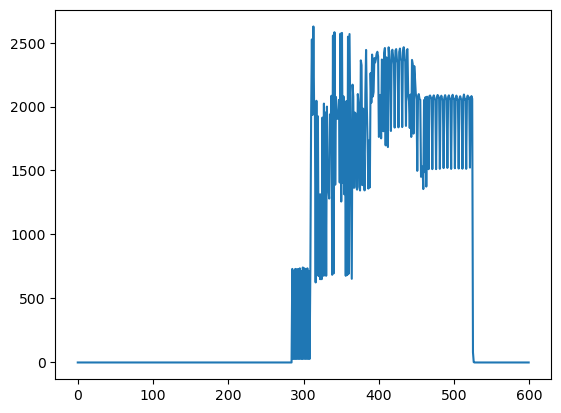

In [7]:
plt.plot((normalized_model_input)[0,:, 0])

[[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.  

"with open('199073_outputs.pkl', 'wb') as f:\n    pickle.dump([wanted_x_train_tensor, model_output, embedding_output, shapeg_output, scaleg_output, gate_output, survival_output], f)"

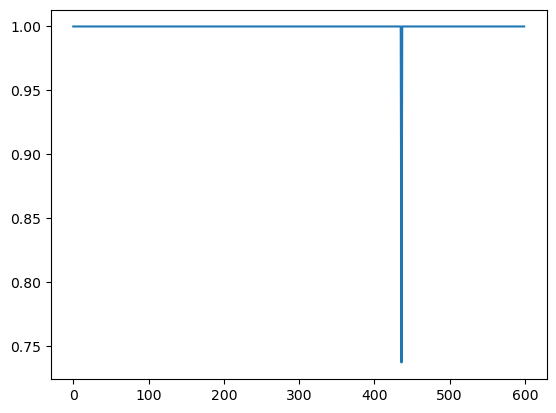

In [9]:
#wanted_x_train_tensor = torch.tensor(x_train_df).float()[130322:130323]
#print(wanted_x_train_tensor.shape)
with open('models/rt_model_latest_pcb.pkl', 'rb') as f:
    loaded_model = pickle.load(f)[0][0]

'''model_output = model(wanted_x_train_tensor)
embedding_output = embedding(wanted_x_train_tensor)
shapeg_output = shapeg(embedding_output)
scaleg_output = scaleg(embedding_output)
gate_output = gate(embedding_output)'''
wanted_x_train_tensor = normalized_model_input[0]
survival_output = loaded_model._model.predict_survival(np.array(wanted_x_train_tensor).astype(float), [400])
plt.plot(survival_output)
#plt.ylim(0, 1.1)
'''with open('199073_outputs.pkl', 'wb') as f:
    pickle.dump([wanted_x_train_tensor, model_output, embedding_output, shapeg_output, scaleg_output, gate_output, survival_output], f)'''

In [77]:
print(shapeg_output.detach().numpy())

[[ 1.1842422  -0.05633846 -3.2683992  -3.445462   -0.81335866 -0.36322984
   0.28849062  1.2793312  -1.6062686  -0.28747058]]


In [78]:
print(scaleg_output.detach().numpy())

[[-0.45699832 -0.2862345  -0.89500004  1.4950056  -0.09478718 -0.9560814
   1.0768062   0.3008911   0.02600932  0.20887306]]


In [79]:
print(gate_output.detach().numpy())

[[-0.22178651  1.3105441   1.4135916  -1.6821411  -0.29370058  0.15051661
   1.1983227   1.1765492  -0.5026573   0.4899634 ]]


In [9]:
xrep = embedding.forward(wanted_x_train_tensor)
dim = x_train_tensor.shape[0]
print(a.act(shapeg(xrep))+a.shape['1'].expand(dim, -1),
           a.act(scaleg(xrep))+a.scale['1'].expand(dim, -1),
           gate(xrep)/a.temp)


torch.Size([1, 1000])
torch.Size([1, 3])
tensor([[0.9874, 1.0554, 1.0971]], grad_fn=<AddBackward0>) tensor([[1.1052, 0.9778, 0.9912]], grad_fn=<AddBackward0>) tensor([[ 0.1165,  0.0377, -0.0991]], grad_fn=<DivBackward0>)


In [105]:
from keras.models import load_model
x_train_keras = np.array(x_train_tensor)
embedding_keras = load_model('embedding.h5')
shapeg_keras = load_model('shapeg.h5')
scaleg_keras = load_model('scaleg.h5')
gate_keras = load_model('gate.h5')
print(x_train_keras.shape)
xred_keras = embedding_keras.predict(x_train_keras)

print(np.tanh(shapeg_keras.predict(xred_keras))+np.array([1,1,1]), 
      np.tanh(scaleg_keras.predict(xred_keras))+np.array([1,1,1]),
        gate_keras.predict(xred_keras))

(1, 179)
1/1 [==============================] - 0s 24ms/step
[[0.98744142 1.05535991 1.097114  ]] [[1.10518538 0.97778107 0.99118527]] [[ 0.11653557  0.03767988 -0.09908683]]
